# MCP介绍

MCP（Model Context Protocol，模型上下文协议）是一个开源协议，旨在标准化AI应用与数据源、工具之间的连接方式。简单来说，它就像AI世界的“USB标准”，让不同AI模型可以轻松、安全地访问各种外部资源和功能。

# MCP的特点

1.协议标准化 – 统一 JSON-RPC 2.0 消息格式，任何兼容 MCP 的主机（Claude Desktop、Cursor 等）都能即插即用。

2.本地优先 – 敏感数据留在本地，API 密钥不再暴露给模型提供商。

3.动态扩展 – 新增工具只需启动一个新的 MCP Server，无需改模型或主程序。

4.安全隔离 – 双层授权 + 最小权限 + 端到端加密。

# MCP典型使用场景

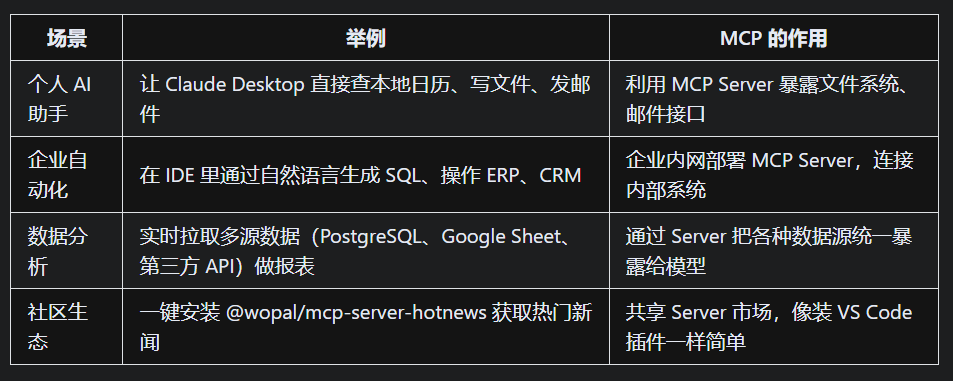

# MCP vs Function Calling vs Tool

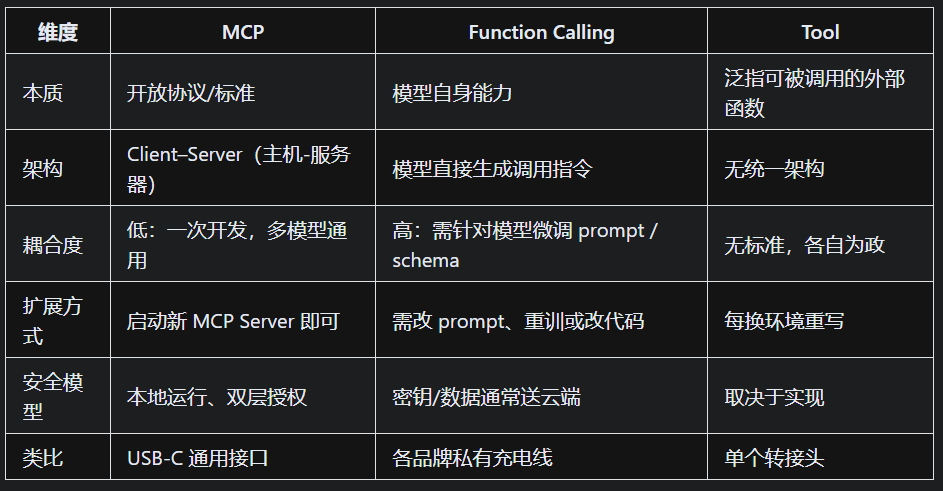

Function Call是大型语言模型（LLM）与外部工具或API交互的核心机制。它是大模型的一个基础能力，就是识别什么时候要工具，可能需要啥类型的工具的能力。

而MCP则是工具分类的箱子。因此MCP不是要取代Function Call，而是要在Function Call基础上，联合Agent一起去完成复杂任务。

如果把整个工具调用的流程剖析开来，实际是“Function Call +Agent + MCP系统的组合。”用一句话说清楚：大模型通过FunctionCall表达，我要调用什么工具，Agent遵循指令执行工具的调用，而MCP则是提供了一种统一的工具调用规范。

# 架构原理
—————————————————————————————————————————
## 工作原理
MCP采用CS架构（客户端-服务器），MCP的技术架构可以简单理解为一个由三个核心部分组成的系统：MCP Host、MCP Client和MCP Server，总体架构如下图所示。

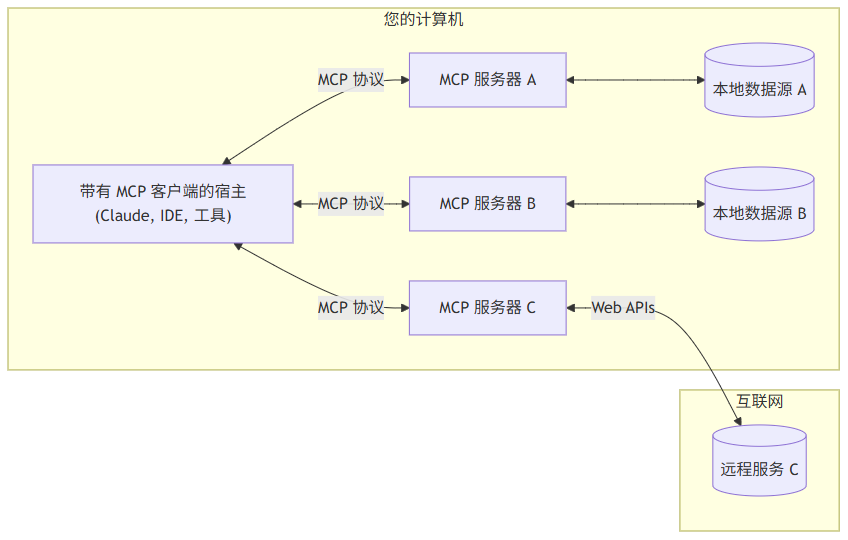

### MCP主机（MCP Hosts）
MCP主机是发起请求的AI应用程序，它们希望通过MCP协议访问外部数据或工具。例如：Claude Desktop、AI驱动的IDE（如Cursor）、其他AI应用（如聊天机器人、自动化助手等）

### MCP客户端（MCP Clients）
MCP客户端是MCP主机和MCP服务器之间的桥梁，与服务器一对一进行连接，负责与服务器进行通信，执行数据请求和工具调用。它的主要功能包括：

从MCP服务器获取可用的工具列表。

将用户的查询和工具描述一起发送给大模型。

接收大模型的决策，判断是否需要使用工具。

通过MCP服务器调用相应的工具，并获取返回结果。

将结果反馈给大模型，由大模型生成最终的自然语言响应。

### MCP服务器（MCP Servers）
MCP服务器是整个架构的核心，它实现了MCP协议，并提供各种功能来支持AI应用。它主要负责：

资源：提供可被读取的数据，如本地文件、API响应、数据库等。

工具：提供可以被大模型调用的函数或操作。

提示词：提供预定义的提示词模板，帮助用户完成特定任务。

每个MCP服务器通常专注于特定的任务，例如：读取和写入浏览器数据、访问本地文件系统、操作Git仓库、连接远程API等等。

### 本地数据源（Local Data Sources）
MCP服务器可以访问计算机上的本地资源，例如：本地文件（如PDF、Word文档、代码文件）、本地数据库（如SQLite、PostgreSQL）、其他本地应用的数据等等。本地数据源的特点是数据不会上传到远端，确保数据安全性。

### 远程服务（Remote Services）
MCP服务器也可以连接到远程资源，例如：在线API、企业内部系统、其他基于云端的数据服务等等。远程服务通常通过API访问，并由MCP服务器进行管理，来确保访问权限的控制。

# MCP项目实践

LangChain调用MCP是可以将MCP的工具直接转换为LangChain的工具，然后通过预定义的MCP_Client实现与外部MCP的读写操作，换而言之就是我们需要改写原先的client，将原先的Function calling调用逻辑修改为LangChain调用逻辑

以下代码为mcp server


In [ ]:
import json
import os
import httpx
import dotenv
from mcp.server.fastmcp import FastMCP
from loguru import logger

dotenv.load_dotenv()

# 创建FastMCP实例，用于启动天气服务器SSE服务
mcp = FastMCP("WeatherServerSSE", host="0.0.0.0", port=8000)

@mcp.tool()
def get_weather(city: str) -> str:
    """
    查询指定城市的即时天气信息。
    参数 city: 城市英文名，如 Beijing
    返回: OpenWeather API 的 JSON 字符串
    """
    url = "https://api.openweathermap.org/data/2.5/weather"
    params = {
        "q": city,
        "appid": os.getenv("OPENWEATHER_API_KEY"),
        "units": "metric",
        "lang": "zh_cn"
    }
    resp = httpx.get(url, params=params, timeout=10)
    data = resp.json()
    logger.info(f"查询 {city} 天气结果：{data}")
    return json.dumps(data, ensure_ascii=False)


if __name__ == "__main__":
    logger.info("启动 MCP SSE 天气服务器，监听 http://0.0.0.0:8000/sse")
    # 运行MCP客户端，使用Server-Sent Events(SSE)作为传输协议
    mcp.run(transport="sse")


以下代码为langchain客户端

In [ ]:
import asyncio
import json
from typing import Any, Dict
from dotenv import load_dotenv
from langchain_classic import hub
from langchain_classic.agents import AgentExecutor, create_openai_tools_agent
from langchain_mcp_adapters.client import MultiServerMCPClient
from langchain_ollama import ChatOllama
from loguru import logger

# 加载 .env 文件中的环境变量，override=True 表示覆盖已存在的变量
load_dotenv(override=True)


def load_servers(file_path: str = "mcp.json") -> Dict[str, Any]:
    """
    从指定的 JSON 文件中加载 MCP 服务器配置。

    参数:
        file_path (str): 配置文件路径，默认为 "mcp.json"

    返回:
        Dict[str, Any]: 包含 MCP 服务器配置的字典，若文件中没有 "mcpServers" 键则返回空字典
    """
    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)
        return data.get("mcpServers", {})


async def run_chat_loop() -> None:
    """
    启动并运行一个基于 MCP 工具的聊天代理循环。

    该函数会：
    1. 加载 MCP 服务器配置；
    2. 初始化 MCP 客户端并获取工具；
    3. 创建基于 Ollama 的语言模型和代理；
    4. 启动命令行聊天循环；
    5. 在退出时清理资源。

    返回:
        None
    """
    # 1️⃣ 加载服务器配置
    servers_cfg = load_servers()

    # 2️⃣ 初始化 MCP 客户端并获取工具
    mcp_client = MultiServerMCPClient(servers_cfg)
    tools = await mcp_client.get_tools()
    logger.info(f"✅ 已加载 {len(tools)} 个 MCP 工具： {[t.name for t in tools]}")

    # 3️⃣ 初始化语言模型、提示模板和代理执行器
    llm = ChatOllama(model="qwen3:14b", reasoning=False)
    prompt = hub.pull("hwchase17/openai-tools-agent")
    agent = create_openai_tools_agent(llm, tools, prompt)
    agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

    # 4️⃣ CLI 聊天
    logger.info("\n🤖 MCP Agent 已启动，输入 'quit' 退出")
    while True:
        user_input = input("\n你: ").strip()
        if user_input.lower() == "quit":
            break
        try:
            result = await agent_executor.ainvoke({"input": user_input})
            print(f"\nAI: {result['output']}")
        except Exception as exc:
            logger.error(f"\n⚠️  出错: {exc}")

    # 5️⃣ 清理
    logger.info("🧹 会话已结束，Bye!")


if __name__ == "__main__":
    # 启动异步事件循环并运行聊天代理
    asyncio.run(run_chat_loop())
